In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import requests

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows: 'Malgun Gothic', MacOS: 'AppleGothic', Linux: 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False     # 그래프에서 마이너스 기호 깨짐 방지

In [3]:
# 네이버 API 인증 정보
client_id = 'YaKyDrFyIZDRfIiRAwBj'  # 사용자 아이디
client_secret = 'hknmr5WHGm'  # 사용자 시크릿

In [4]:
# 업비트 데이터를 가져오는 함수
def fetch_upbit_data(market="KRW-BTC", count=200):
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market, "count": count}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"업비트 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.sort_values(by="date", inplace=True)
    return df

In [5]:
# 뉴스 데이터를 가져오는 함수
def fetch_news_data(query, display=10):
    url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display={display}"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"뉴스 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    return pd.DataFrame(data['items'])

In [6]:
# 감정 분석을 위한 함수
def analyze_sentiment(texts):
    tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    sentiments = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        sentiment = torch.argmax(outputs.logits, dim=1).item() + 1  # 감정 점수: 1~5
        sentiments.append(sentiment)

    return sentiments

In [7]:
# 멀티모달 데이터 생성 함수
def create_multimodal_sequences(prices, sentiments, seq_length):
    sequences = []
    labels = []
    for i in range(len(prices) - seq_length):
        seq = np.column_stack((prices[i:i + seq_length], sentiments[i:i + seq_length]))
        label = prices[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [8]:
# BTC/KRW 시장 데이터 가져오기
df_price = fetch_upbit_data()
if df_price is None:
    raise ValueError("업비트 데이터를 가져오지 못했습니다.")

In [9]:
# 뉴스 데이터 가져오기
news_df = fetch_news_data("비트코인")
if news_df is None:
    raise ValueError("뉴스 데이터를 가져오지 못했습니다.")

In [13]:
# 뉴스 데이터 날짜별 처리
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')  # 뉴스 데이터의 날짜 열
news_df['date'] = news_df['pubDate'].dt.date  # 날짜만 추출

# NaT (not a time) 값이 있을 경우 처리
news_df = news_df.dropna(subset=['date'])

# 감정 분석 수행
news_df['sentiment'] = analyze_sentiment(news_df['title'])  # 뉴스 제목 감정 분석

# 날짜별 평균 감정 점수 계산
sentiment_by_date = news_df.groupby('date')['sentiment'].mean().reset_index()
sentiment_by_date.columns = ['date', 'average_sentiment']

In [14]:
# 감정 점수 병합
merged_df = pd.merge(df_price, sentiment_by_date, on='date', how='left')
merged_df['average_sentiment'].fillna(2.5, inplace=True)  # 결측치는 중립 값으로 채움

C:\Users\kgg07\AppData\Local\Temp\ipykernel_22392\1982430085.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['average_sentiment'].fillna(2.5, inplace=True)  # 결측치는 중립 값으로 채움


In [15]:
# 데이터 스케일링
scaler = MinMaxScaler()
merged_df['scaled_price'] = scaler.fit_transform(merged_df['price'].values.reshape(-1, 1))
merged_df['scaled_sentiment'] = scaler.fit_transform(merged_df['average_sentiment'].values.reshape(-1, 1))

In [16]:
# 멀티모달 데이터 준비
sequence_length = 10
X, y = create_multimodal_sequences(
    merged_df['scaled_price'].values,
    merged_df['scaled_sentiment'].values,
    sequence_length
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# GRU 모델 생성
model = Sequential([
    GRU(128, input_shape=(sequence_length, 2), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

C:\Users\kgg07\anaconda3\envs\learning3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [19]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.0970 - val_loss: 0.0234
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0055 - val_loss: 0.0025
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.

In [20]:
# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f"테스트 손실: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0021
테스트 손실: 0.0020322808995842934


In [21]:
# 예측값과 실제값 비교
predictions = model.predict(X_test)
original_scale_predictions = scaler.inverse_transform(predictions)
original_scale_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


In [22]:
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:.2f}, 실제값: {true[0]:.2f}")


샘플 예측값과 실제값:
예측값: 2.77, 실제값: 2.75
예측값: 2.77, 실제값: 2.77
예측값: 2.55, 실제값: 2.55
예측값: 2.53, 실제값: 2.56
예측값: 2.52, 실제값: 2.53


In [23]:
# 감정 분석 결과의 분포 (긍정, 중립, 부정)
sentiment_counts = news_df['sentiment'].value_counts().sort_index()

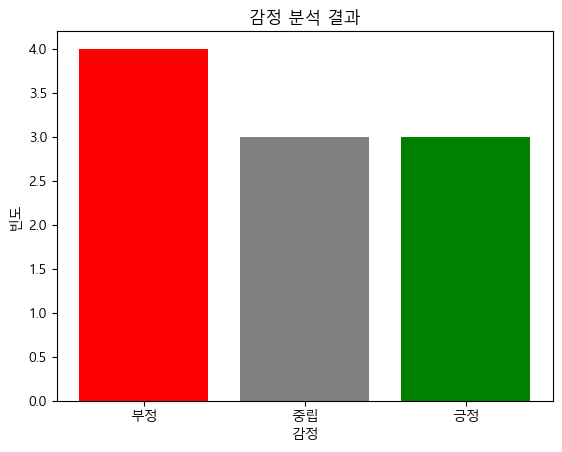

In [26]:
# 감정 분석 결과의 빈도 계산
sentiment_counts = pd.Series(news_df['sentiment'].value_counts()).sort_index()

# 1부터 5까지 점수의 카운트가 없다면 기본 값 0으로 처리
sentiment_counts = sentiment_counts.reindex([1, 2, 3, 4, 5], fill_value=0)

# 감정 점수의 구간을 정의 (1~5 점)
sentiment_labels = ['부정', '중립', '긍정']
sentiment_categories = {
    '부정': sentiment_counts[1] + sentiment_counts[2],  # 1, 2 점은 부정
    '중립': sentiment_counts[3],  # 3 점은 중립
    '긍정': sentiment_counts[4] + sentiment_counts[5],  # 4, 5 점은 긍정
}

# 시각화 (부정, 중립, 긍정 비율)
categories = list(sentiment_categories.keys())
counts = list(sentiment_categories.values())

plt.bar(categories, counts, color=['red', 'gray', 'green'])
plt.title('감정 분석 결과')
plt.xlabel('감정')
plt.ylabel('빈도')
plt.show()

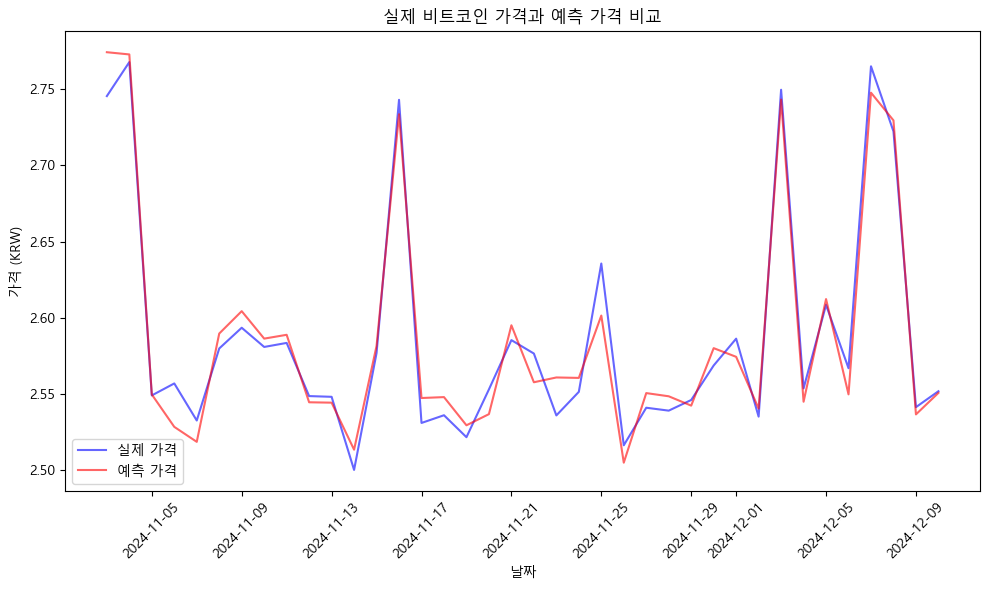

In [28]:
# 예측값과 실제 비트코인 가격 비교 (모의 비트코인 차트)
plt.figure(figsize=(10, 6))
plt.plot(merged_df['date'][-len(original_scale_y_test):], original_scale_y_test, label='실제 가격', color='blue', alpha=0.6)
plt.plot(merged_df['date'][-len(original_scale_predictions):], original_scale_predictions, label='예측 가격', color='red', alpha=0.6)
plt.title('실제 비트코인 가격과 예측 가격 비교')
plt.xlabel('날짜')
plt.ylabel('가격 (KRW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()